# Lectura y graficación de una señal almacenada en un archivo txt

In [310]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, iirnotch, filtfilt

## Leemos el archivo

In [311]:

def map_v(value, in_min, in_max, out_min, out_max):
    return (value - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

Ts = 1/1000
Fs = 1/Ts
'''
Basal 1
Basal 2
Post-ejercicio
Respiracion
Patron
'''
adr = 'Imagenes/'
file = 'Patron'
array = np.genfromtxt(file + ".txt", delimiter="	0	0	0	0	")
array = array[:,1]
aux = array
array = map_v(array, 0, 1023, -1.5, 1.5)
t = np.arange(0, len(array))*Ts
print('Seconds: ',len(t)*Ts)

Seconds:  168.9


## Ploteamos la lectura

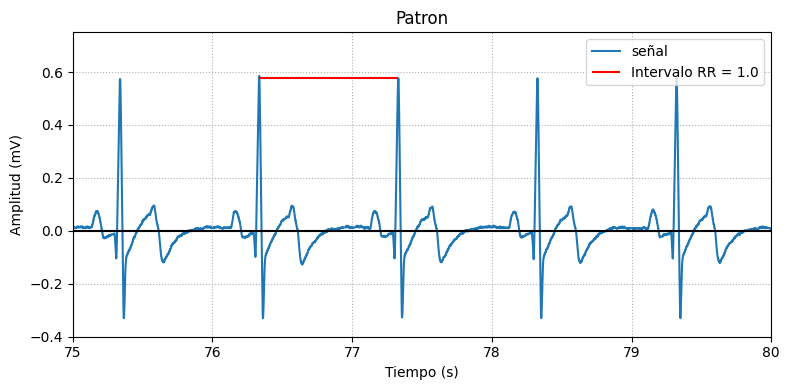

In [312]:
x1 = 75; x2 = 80
fsize = 8

fig = plt.figure(figsize = (fsize,4))
plt.plot(t, array, label="señal")      # graficamos la señal
plt.grid(linestyle=":")
plt.title(file)
plt.xlim(x1,x2)
plt.ylim(-0.4,0.75)
plt.axhline(0.0, color='k')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")

# Calculamos el intervalo RR
t1 = 76000; t2 = 78000; tmid = int(np.ceil((t1+t2)/2))

R1 = t[np.argmax(array[t1:tmid])+t1]
R2 = t[np.argmax(array[tmid:t2])+tmid]
IntervaloRR = R2-R1
if (np.max(array[t1:tmid])>np.max(array[t1:tmid])):
    y = np.max(array[t1:tmid])
else:
    y = np.max(array[tmid:t2])
plt.hlines(y,R1,R2, color='r', label = 'Intervalo RR = ' + str(np.round(IntervaloRR,2)))
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

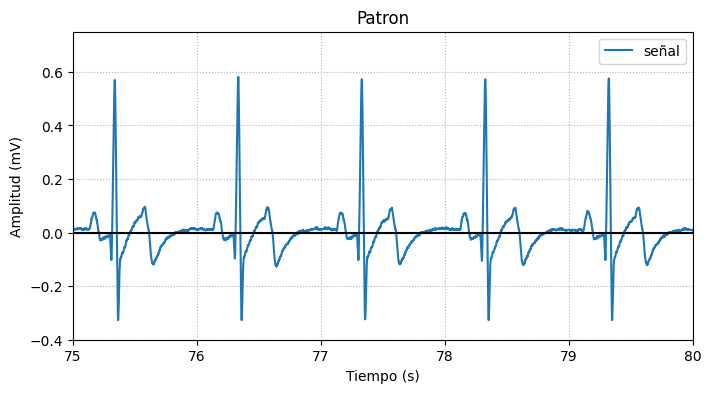

In [313]:
# notch
f0 = 60.0
b,a = iirnotch(f0, 30.0, 1000.0)
notch = filtfilt(b, a, array)

plt.figure(figsize = (8,4))
plt.plot(t, notch, label="señal")      # graficamos la señal
plt.grid(linestyle=":")
plt.title(file)
plt.xlim(x1,x2)
plt.ylim(-0.4,0.75)
plt.axhline(0.0, color='k')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.legend(loc="upper right")
plt.show()

## Filtramos la señal

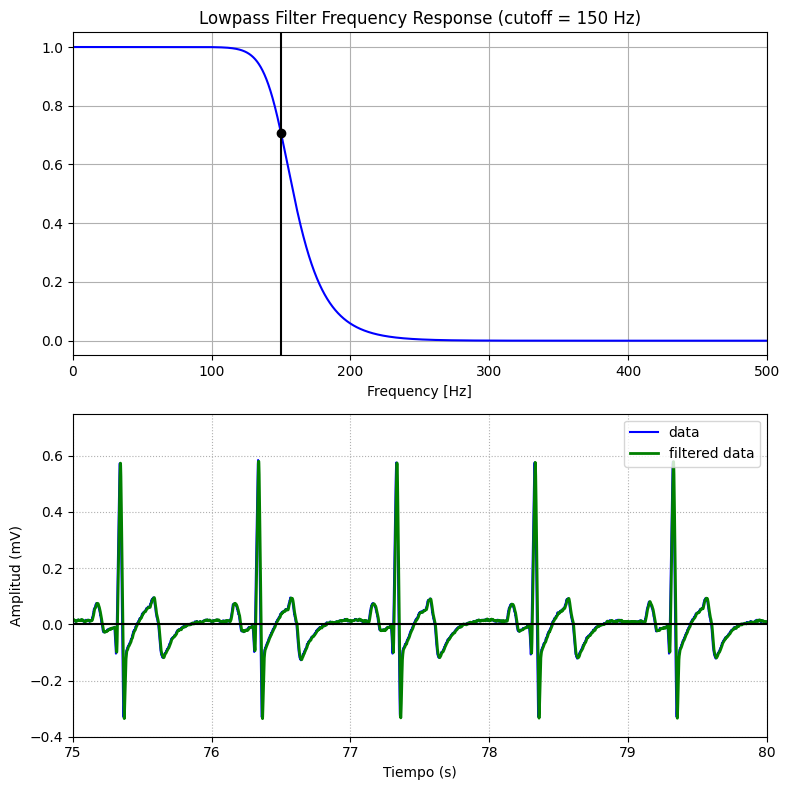

In [314]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 8
fs = 1000.0       
cutoff = 150.0

b, a = butter_lowpass(cutoff, fs, order)

f = plt.figure(2, figsize = (fsize,8))

# Plotting the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response (cutoff = 150 Hz)")
plt.xlabel('Frequency [Hz]')
plt.grid()

data = array

# Filtering and plotting
y = butter_lowpass_filter(data, cutoff, fs, order)
plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.grid(linestyle=":")
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (mV)')
plt.xlim(x1,x2)
plt.ylim(-0.4,0.75)
plt.axhline(0.0, color='k')
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.tight_layout()
plt.show()

## La forma de saber la frecuencia de la señal es viendo en el dominio de la frecuencia

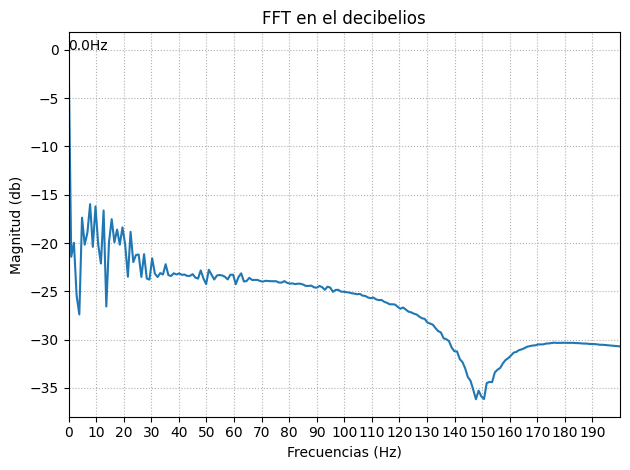

In [315]:
N = 2**10                                     # 10 bits, 0-1023

signal1 = butter_lowpass_filter(aux, cutoff, fs, order)

signal_fft = np.fft.fft(signal1, N)           # fft magtinud
signal_fft = np.round(np.abs(signal_fft),3)[0:N//2] # nos quedamos con los componente de la derecha de la FFT
signal_aux = signal_fft/signal_fft.max()     # hallamos el maximo para pasar la magnitud a escala db

with np.errstate(divide='ignore'):
    signal_fft_db = 10*np.log10(signal_aux)  # , out=signal_aux, where=signal_aux >= 0 para evitar division por zero

F_list = np.linspace(0,Fs/2, N//2)
F = np.round(F_list[np.argmax(signal_fft_db)], 1)   # argmax, encuentra el argumento max en un array

Ffig = plt.figure()
plt.plot(F_list, signal_fft_db)  #10 * np.log10(P / Pref) , decibelios
plt.text(F,0, f"{F}Hz")
plt.grid(linestyle=":")
plt.ylabel("Magnitud (db)")
plt.xlabel("Frecuencias (Hz)")
plt.title("FFT en el decibelios")
plt.xlim([0,200])
plt.xticks(np.arange(0,200,10))
plt.tight_layout()
plt.show()


In [317]:
fig.savefig(adr + file + ' Raw_Signal.png'); f.savefig(adr + file + ' Filtered_Signal.png'); Ffig.savefig(adr + file + ' Freq_response.png')